<a href="https://colab.research.google.com/github/Shubhankar9934/SalesPredictionCodeClause/blob/main/salesPerdiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"shubhankarkumarmnnit","key":"ae6162aa19cec8caa6e224a1caa57e6d"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                                title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                  8KB  2023-02-01 12:22:51           6047        181  1.0              
amaanansari09/top-100-songs                                        Top 100 songs                                     6KB  2023-02-16 18:55:35            814         27  1.0              
datascientistanna/customers-dataset                                Shop Customer Data                               23KB  2023-02-07 18:42:21           4626        116  1.0              
thedevastator/airbnb-prices-in-european-cities                   

In [6]:
! kaggle competitions download -c 'store-sales-time-series-forecasting'

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [8]:
! unzip store-sales-time-series-forecasting.zip -d train

Archive:  store-sales-time-series-forecasting.zip
replace train/holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/holidays_events.csv  
replace train/oil.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/oil.csv           
replace train/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/sample_submission.csv  
replace train/stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/stores.csv        
replace train/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/test.csv          
replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/train.csv         y

replace train/transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train/transactions.csv  


In [9]:
# Import required libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
pio.templates.default = "none"


# Load data
df_trans = pd.read_csv('train/transactions.csv')

# Convert to datetime
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


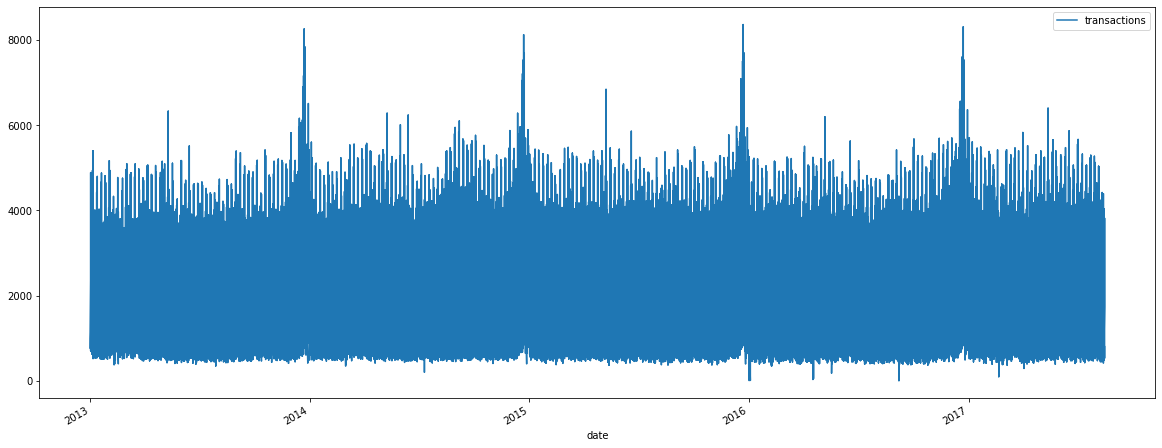

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
df_trans.plot.line(x="date", y="transactions",
                 ax = axes,
#                  rot=0
                )
plt.show()

In [11]:
# Create function to group by the called frequency (W = week, M = month, Y = year)
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

df_grouped_trans_m = grouped(df_trans, 'date', 'M', 'transactions')
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w.head()

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975


Text(0.5, 1.0, 'Average Daily Sales per Week')

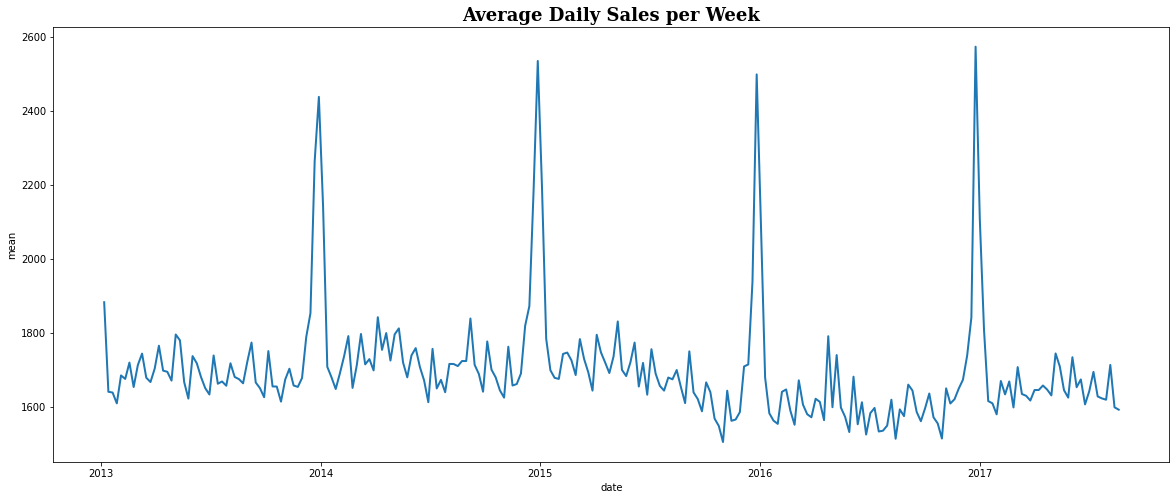

In [12]:
fig = plt.figure(figsize = (20, 8))
sns.lineplot(x = df_grouped_trans_w['date'], y= df_grouped_trans_w['mean'], linewidth=2, )
plt.title("Average Daily Sales per Week",
          fontsize = 18,
          fontweight = 'bold',
          fontfamily = 'serif',
          loc = 'center')

Text(0.5, 1.0, 'Average Daily Sales per Month')

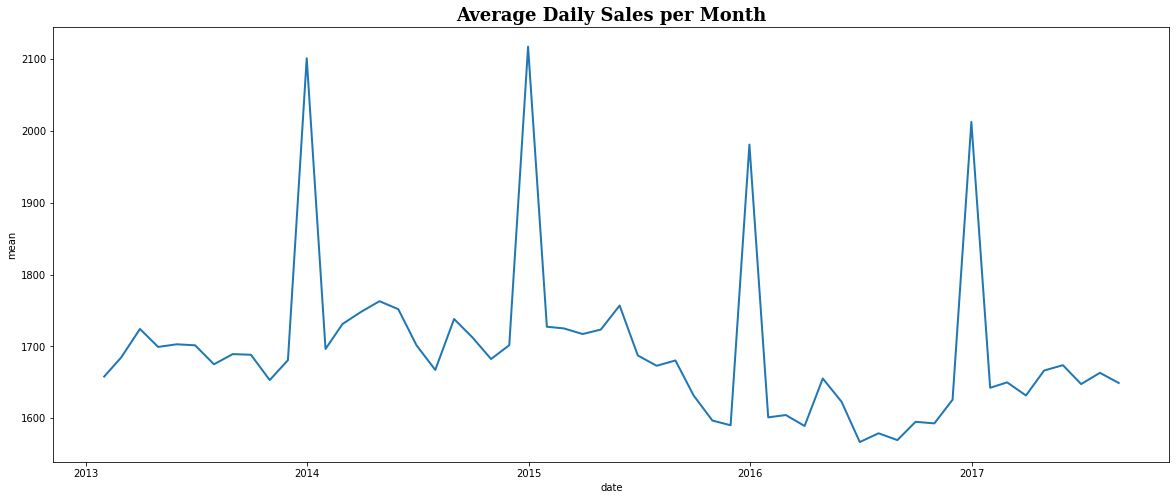

In [13]:
fig = plt.figure(figsize = (20, 8))
sns.lineplot(x = df_grouped_trans_m['date'], y= df_grouped_trans_m['mean'], linewidth=2, )
plt.title("Average Daily Sales per Month",
          fontsize = 18,
          fontweight = 'bold',
          fontfamily = 'serif',
          loc = 'center')

In [14]:
print(df_grouped_trans_m.shape)

# first 36 rows as training
train = df_grouped_trans_m[0:36]

# remaining rows for testing
test = df_grouped_trans_m[36:]

print(train.shape, test.shape)

(56, 2)
(36, 2) (20, 2)


In [15]:
train.head()

,date,mean
0,2013-01-31,1657.898624
1,2013-02-28,1684.483696
2,2013-03-31,1724.181627
3,2013-04-30,1699.206522
4,2013-05-31,1702.874396


In [16]:
test

,date,mean
36,2016-01-31,1601.083727
37,2016-02-29,1604.292778
38,2016-03-31,1589.066423
39,2016-04-30,1655.218239
40,2016-05-31,1622.737066
41,2016-06-30,1566.706289
42,2016-07-31,1578.872185
43,2016-08-31,1569.375619
44,2016-09-30,1594.878272
45,2016-10-31,1592.686003


Step 4. ARIMA model

auto_arima() function will be used to automatically select the best parameters for an ARIMA model. It takes several parameters to set a range of values for p, d, q, P, D, Q that the function will explore. For example, start_p=1, start_q=1 and max_p=3, max_q=3 are set as the range for p and q.
The auto_arima() model will use the stepwise=True option to fit the model iteratively and improve the model at each step.
The fitted model is then stored in the model_fit variable and the summary of the model is printed.
Finally, the code uses the predict() function of the fitted model to forecast the next 'n' periods of the time series.

In [17]:
pip install pmdarima --quiet

In [18]:

from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Run combinations of ARIMA(p,d,q)
model_fit = auto_arima(train['mean'],
                       m=12,
                       d=0,
                       D=0,
                       max_order=None,                       
                       max_p=7,
                       max_q=7,
                       max_d=2,
                       max_P=4,
                       max_Q=4,
                       max_D=2,
                       maxiter = 50,
                       alpha = 0.05,
                       n_jobs = -1,
                       seasonal=True,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                      )

model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=444.551, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=445.122, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=442.871, Time=0.68 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=640.994, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=447.070, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=442.953, Time=0.86 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=447.068, Time=0.22 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=445.002, Time=0.28 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=449.069, Time=0.28 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -217.435
Date:                            Sat, 25 Feb 2023   AIC                            442.871
Time:                                    23:14:40   BIC                            449.205
Sample:                                         0   HQIC                           445.081
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1799.8825    349.694      5.147      0.000    1114.495    2485.271
ar.L1         -0.3646      0.160     -2.283      0.022      -0.678      -0.052
ar.S.L12       0.2356      0.119      1.984      0.047       0.003       0.468
sigma2      1.007e+04   2427.891      4.146      0.000    5306.759    1.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.48   Jarque-Bera (JB):                40.48
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.73
Prob(H) (two-sided):                  0.49   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model_fit

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True)

<AxesSubplot:>

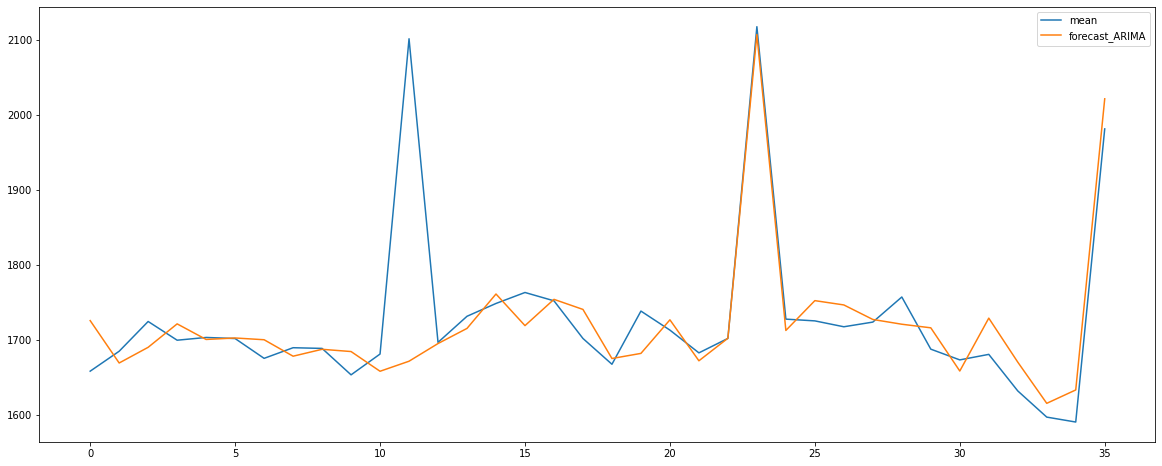

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the ARIMA model
model_ARIMA = ARIMA(train['mean'],
              order=(1,0,0),
              seasonal_order=(2, 0, 0, 12)
            )

# Fit the model
model_ARIMA = model_ARIMA.fit()

train_forecast = train.copy()
test_forecast = test.copy()

train_forecast['forecast_ARIMA'] = model_ARIMA.predict()
train_forecast[['mean','forecast_ARIMA']].plot(figsize=(20,8))

<AxesSubplot:>

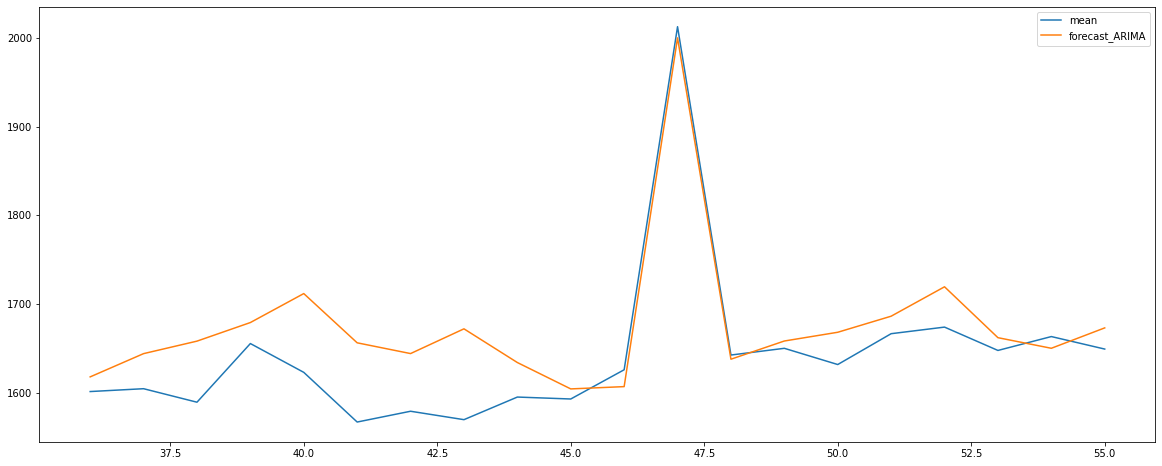

In [22]:
# Forecast and compare against test data

# start date
start = len(train)

# End date
end = len(train)+len(test)-1

test_forecast['forecast_ARIMA'] = model_ARIMA.predict(start=start, end=end, )
test_forecast[['mean','forecast_ARIMA']].plot(figsize=(20,8))

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("RMSE of Auto ARIMA:", np.sqrt(mean_squared_error(test_forecast['mean'], test_forecast['forecast_ARIMA'])))
print("MAE of Auto ARIMA:", mean_absolute_error(test_forecast['mean'], test_forecast['forecast_ARIMA']))

RMSE of Auto ARIMA: 47.292707208954
MAE of Auto ARIMA: 37.11418366717122


2. Facebook Prophet
Both are powerful tools for time series forecasting, but have different strengths and weaknesses.
Prophet is a more user-friendly and flexible model than ARIMA, and it can handle missing data, seasonality, and changepoints automatically. It also provides clear visualizations of the model components.

On the other hand, ARIMA requires more manual tuning of the model parameters and is more sensitive to outliers. It also requires a deeper understanding of the underlying statistical concepts and can be more difficult to interpret. However, ARIMA can be more flexible as it can be extended to SARIMAX model that allows the addition of exogenous variables.

It's important to note that the performance of the model depends on the nature of the data and the task at hand. Both Prophet and ARIMA can be used to achieve good performance on time series forecasting problems, but it's important to try multiple models and techniques, evaluate their performance, and select the best one for your specific dataset.

In [24]:
from prophet import Prophet

In [25]:
train_fb = train.copy()
test_fb = test.copy()

train_fb.columns = ['ds','y']
test_fb.columns = ['ds','y']

train_fb.head()

,ds,y
0,2013-01-31,1657.898624
1,2013-02-28,1684.483696
2,2013-03-31,1724.181627
3,2013-04-30,1699.206522
4,2013-05-31,1702.874396


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwaf8w5q/rjyun86_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwaf8w5q/p7yymync.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95846', 'data', 'file=/tmp/tmpzwaf8w5q/rjyun86_.json', 'init=/tmp/tmpzwaf8w5q/p7yymync.json', 'output', 'file=/tmp/tmpzwaf8w5q/prophet_modelw9z2amgi/prophet_model-20230225231442.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


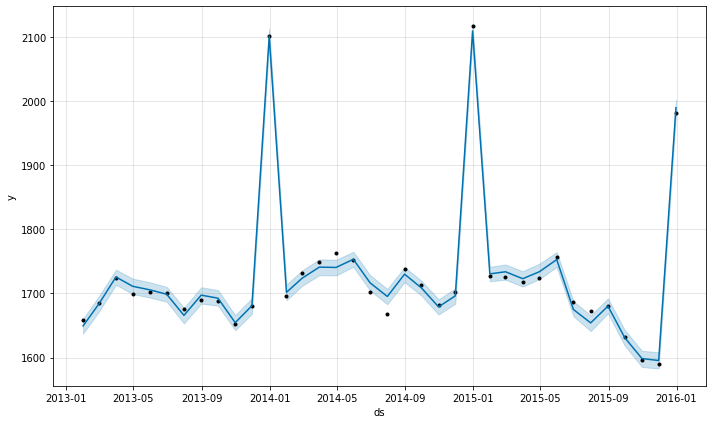

In [26]:
model_prophet = Prophet()
model_prophet.fit(train_fb)

forecast = model_prophet.predict()
fig = model_prophet.plot(forecast)

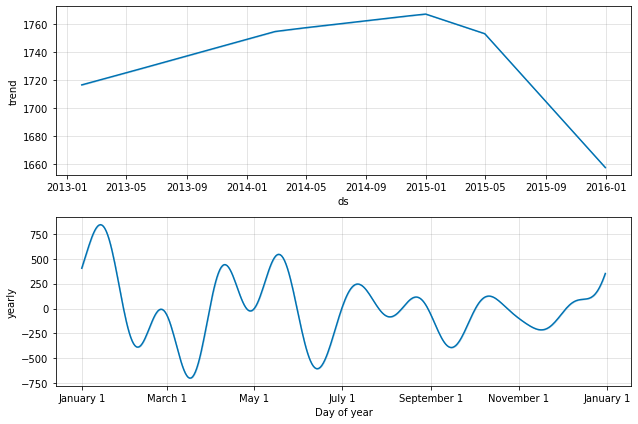

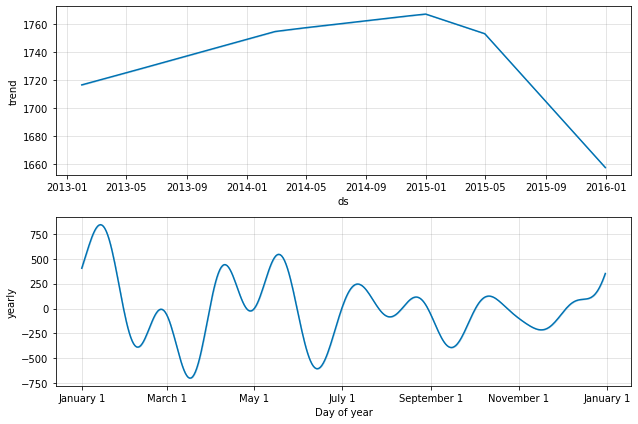

In [27]:
forecast = model_prophet.predict(train_fb)
model_prophet.plot_components(forecast)

<AxesSubplot:>

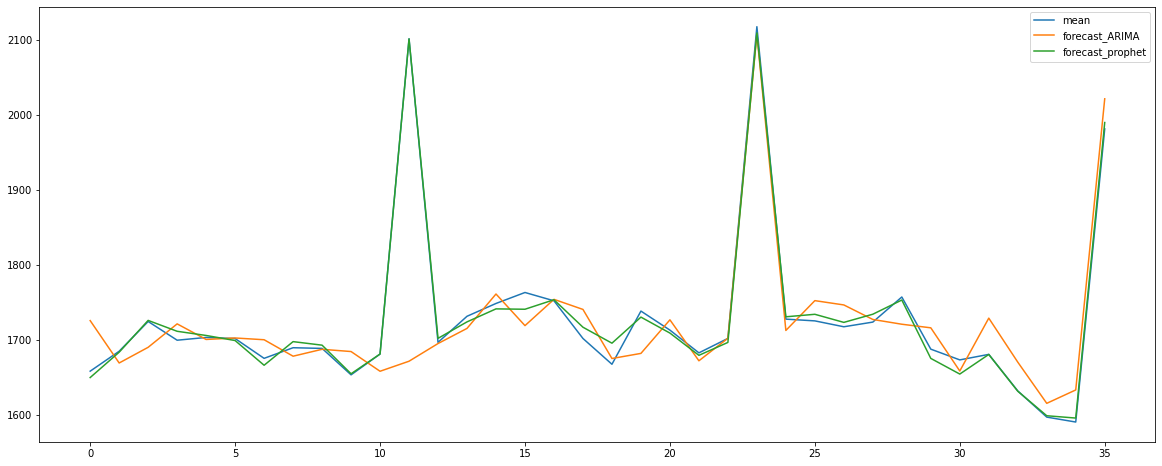

In [28]:
train_forecast['forecast_prophet'] = forecast['yhat']
train_forecast[['mean', 'forecast_ARIMA','forecast_prophet']].plot(figsize=(20,8))

<AxesSubplot:>

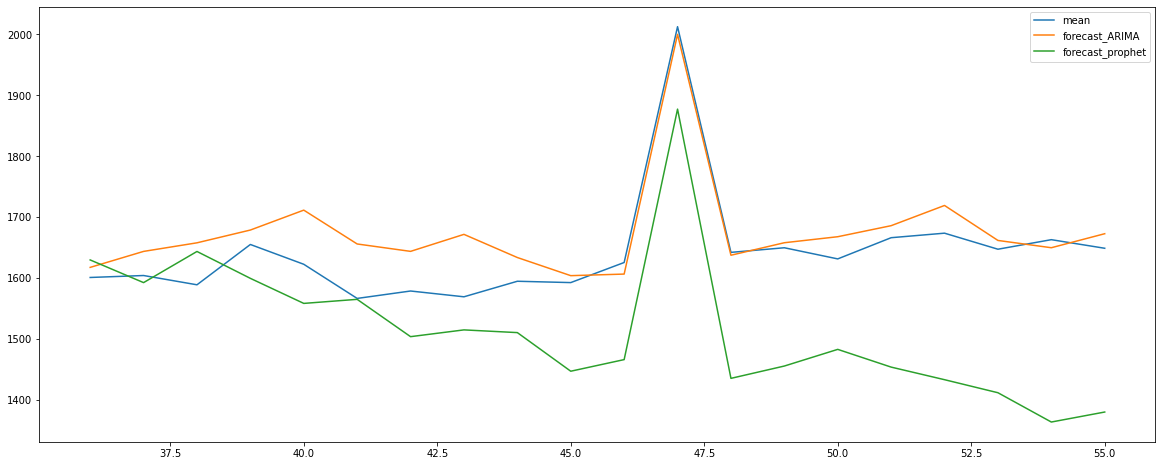

In [29]:
future_data = model_prophet.make_future_dataframe(periods=20, freq='M')
forecast = model_prophet.predict(future_data)

test_forecast['forecast_prophet'] = forecast[36:]['yhat']
test_forecast[['mean','forecast_ARIMA', 'forecast_prophet']].plot(figsize=(20,8))

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("RMSE of Auto ARIMA:", np.sqrt(mean_squared_error(test_forecast['mean'], test_forecast['forecast_ARIMA'])))
print("MAE of Auto ARIMA:", mean_absolute_error(test_forecast['mean'], test_forecast['forecast_ARIMA']))

print("---------------------------------------------\nRMSE of Facebook Prophet:", np.sqrt(mean_squared_error(test_forecast['mean'], test_forecast['forecast_prophet'])))
print("MAE of Facebook Prophet:", mean_absolute_error(test_forecast['mean'], test_forecast['forecast_prophet']))

RMSE of Auto ARIMA: 47.292707208954
MAE of Auto ARIMA: 37.11418366717122
---------------------------------------------
RMSE of Facebook Prophet: 160.33708339307083
MAE of Facebook Prophet: 133.76340316166588


Insights:

Although Facebook Prophet performed better in the training data, it was revealed to perform poorly when validated on testing data. Upon observation, the declining trend made the deviation even worse in the following years. Overfitting may be a concern here.

3. Long Short-Term Memory (LSTMs)
Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) that are particularly well suited for time series forecasting. LSTMs are able to capture long-term dependencies in time series data by using memory cells that can retain information for extended periods of time.

LSTMs take in the historical time series data as input, and use this data to learn the underlying patterns and relationships in the data. Once trained, the LSTM can then be used to make predictions about future events in the time series.

First, load the necessary libraries

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
train = train.set_index('date')
test = test.set_index('date')

In [33]:
train.reset_index()

scaler = MinMaxScaler()
train.head(), test.head()

(                   mean
 date                   
 2013-01-31  1657.898624
 2013-02-28  1684.483696
 2013-03-31  1724.181627
 2013-04-30  1699.206522
 2013-05-31  1702.874396,                    mean
 date                   
 2016-01-31  1601.083727
 2016-02-29  1604.292778
 2016-03-31  1589.066423
 2016-04-30  1655.218239
 2016-05-31  1622.737066)

In [34]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [35]:
scaled_train[:10]

array([[0.12864097],
       [0.17905256],
       [0.25432924],
       [0.20697053],
       [0.21392569],
       [0.21118059],
       [0.16109303],
       [0.18796273],
       [0.18623404],
       [0.11937674]])

In [36]:
# We do the same thing, but now instead for 12 months
n_input = 4
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [37]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50
32/32 [==============================] - 2s 5ms/step - loss: 0.0882
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0546
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0528
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0534
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0517
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0514
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0536
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0527
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0519
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0503
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0508
Epoch 13/50
32/32 [==============================

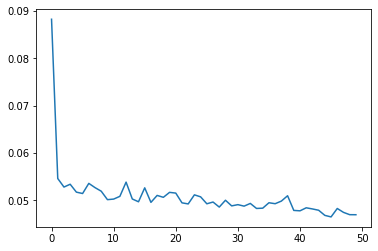

In [38]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [39]:
last_train_batch = scaled_train[-4:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 1s 837ms/step


array([[0.53174263]], dtype=float32)

In [40]:
scaled_test[0]


array([0.02090646])

In [41]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 48ms/step


In [42]:
test_predictions

[array([0.53174263], dtype=float32),
 array([0.42927146], dtype=float32),
 array([0.33044198], dtype=float32),
 array([0.28543967], dtype=float32),
 array([0.2784676], dtype=float32),
 array([0.27404672], dtype=float32),
 array([0.27080494], dtype=float32),
 array([0.2696542], dtype=float32),
 array([0.26945266], dtype=float32),
 array([0.2692919], dtype=float32),
 array([0.2692023], dtype=float32),
 array([0.26917627], dtype=float32),
 array([0.26917058], dtype=float32),
 array([0.26916566], dtype=float32),
 array([0.2691634], dtype=float32),
 array([0.2691628], dtype=float32),
 array([0.26916263], dtype=float32),
 array([0.2691625], dtype=float32),
 array([0.26916242], dtype=float32),
 array([0.2691624], dtype=float32)]

In [43]:
test.head()

,mean
date,
2016-01-31,1601.083727
2016-02-29,1604.292778
2016-03-31,1589.066423
2016-04-30,1655.218239
2016-05-31,1622.737066


<AxesSubplot:xlabel='date'>

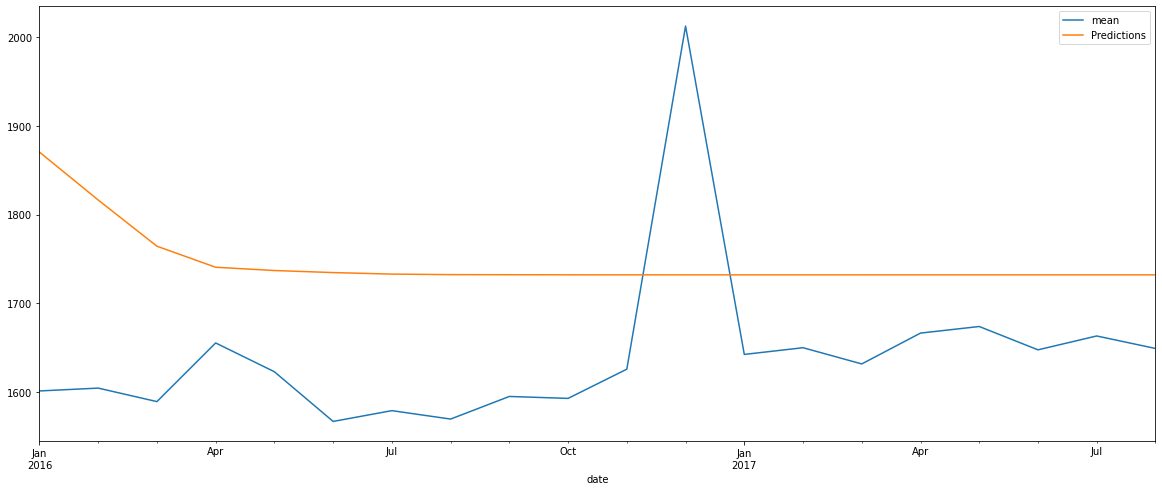

In [44]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(20,8))

4. Exercise: Featured Competition
Let's challenge ourselves and apply these forecasting models we have learned on the featured competition dataset GoDaddy - Microbusiness Density Forecasting.

In [50]:
# Load data
df_daddy = pd.read_csv('train.csv')

# Convert to datetime
df_daddy['first_day_of_month'] = pd.to_datetime(df_daddy['first_day_of_month'], format = "%Y-%m-%d")

# Rename columns
_ = df_daddy[['first_day_of_month', 'microbusiness_density']]
_.rename(columns = {'first_day_of_month':'date', 'microbusiness_density':'density',}, inplace = True)
_.head()

,date,density
0,2019-08-01,3.007682
1,2019-09-01,2.884870
2,2019-10-01,3.055843
3,2019-11-01,2.993233
4,2019-12-01,2.993233


In [51]:
# Group by month
df_grouped_daddy = _.groupby('date')['density'].mean().reset_index()
df_grouped_daddy.head()

,date,density
0,2019-08-01,3.760413
1,2019-09-01,3.703898
2,2019-10-01,3.789975
3,2019-11-01,3.728758
4,2019-12-01,3.723256


Text(0.5, 1.0, 'Average Monthly Microbusiness Density')

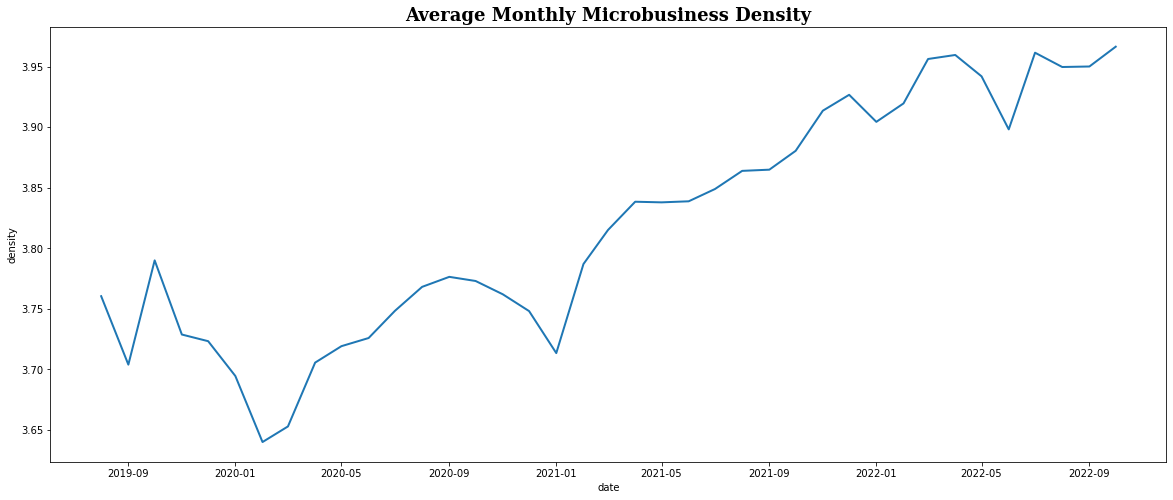

In [52]:
# Plot the graph
fig = plt.figure(figsize = (20, 8))
sns.lineplot(x = df_grouped_daddy['date'], y= df_grouped_daddy['density'], linewidth=2, )
plt.title("Average Monthly Microbusiness Density",
          fontsize = 18,
          fontweight = 'bold',
          fontfamily = 'serif',
          loc = 'center')

In [53]:
# Run combinations of ARIMA(p,d,q)
model_fit = auto_arima(df_grouped_daddy['density'],
                       test='adf', # Adfuller test if the data is stationary or not
#                        m=36,
                       d=1,
                       D=1,
                       start_p=0,
                       start_q=0,
                       max_order=None,                       
                       max_p=7,
                       max_q=7,
                       max_d=2,
                       max_P=4,
                       max_Q=4,
                       max_D=2,
                       maxiter = 50,
                       alpha = 0.05,
#                        seasonal=True,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                      )

model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-148.662, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-148.655, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-148.812, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-149.617, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-148.314, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.583 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  75.808
Date:                Sat, 25 Feb 2023   AIC                           -149.617
Time:                        23:25:07   BIC                           -147.979
Sample:                             0   HQIC                          -149.034
                                 - 39                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011      0.000      4.782      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.16   Prob(JB):                         0.85
Heteroskedasticity (H):               0.46   Skew:                             0.15
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
model_ARIMA

<AxesSubplot:>

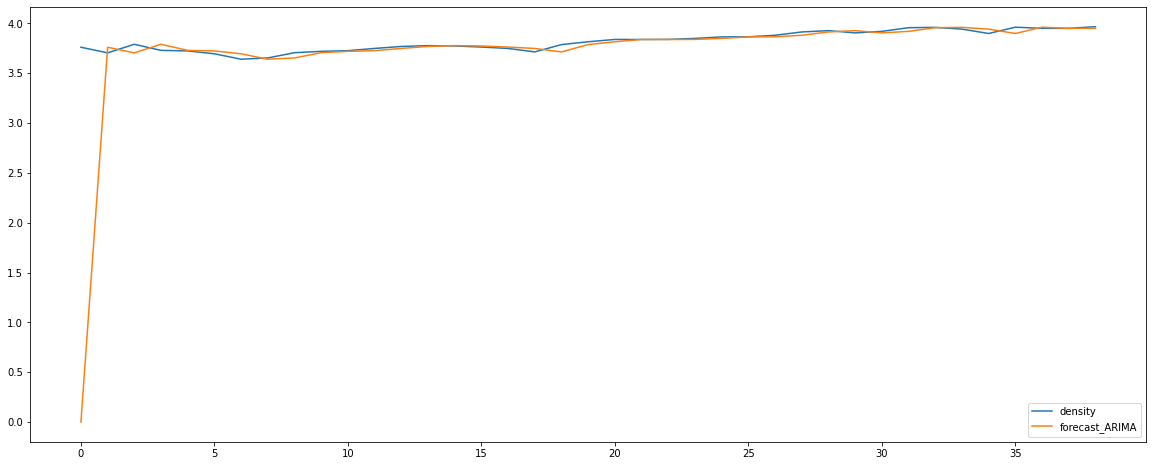

In [55]:
# Fit the ARIMA model
model_ARIMA = ARIMA(df_grouped_daddy['density'],
              order=(0,1,0),
              seasonal_order=(0, 0, 0, 0),
            )

# Fit the model
model_ARIMA = model_ARIMA.fit()

df_grouped_daddy['forecast_ARIMA'] = model_ARIMA.predict()
df_grouped_daddy[['density','forecast_ARIMA']].plot(figsize=(20,8))